# Visual Scanning Exercise

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

In [2]:
from mls import plot_image

Read the test images generated and saved by [this notebook](Supervised.ipynb):

In [3]:
df_img = pd.read_hdf('data/sources_img_test.hf5')
nsrc = pd.read_hdf('data/nsrc_true_test.hf5').values

Plot a page of images to use for visual scanning:

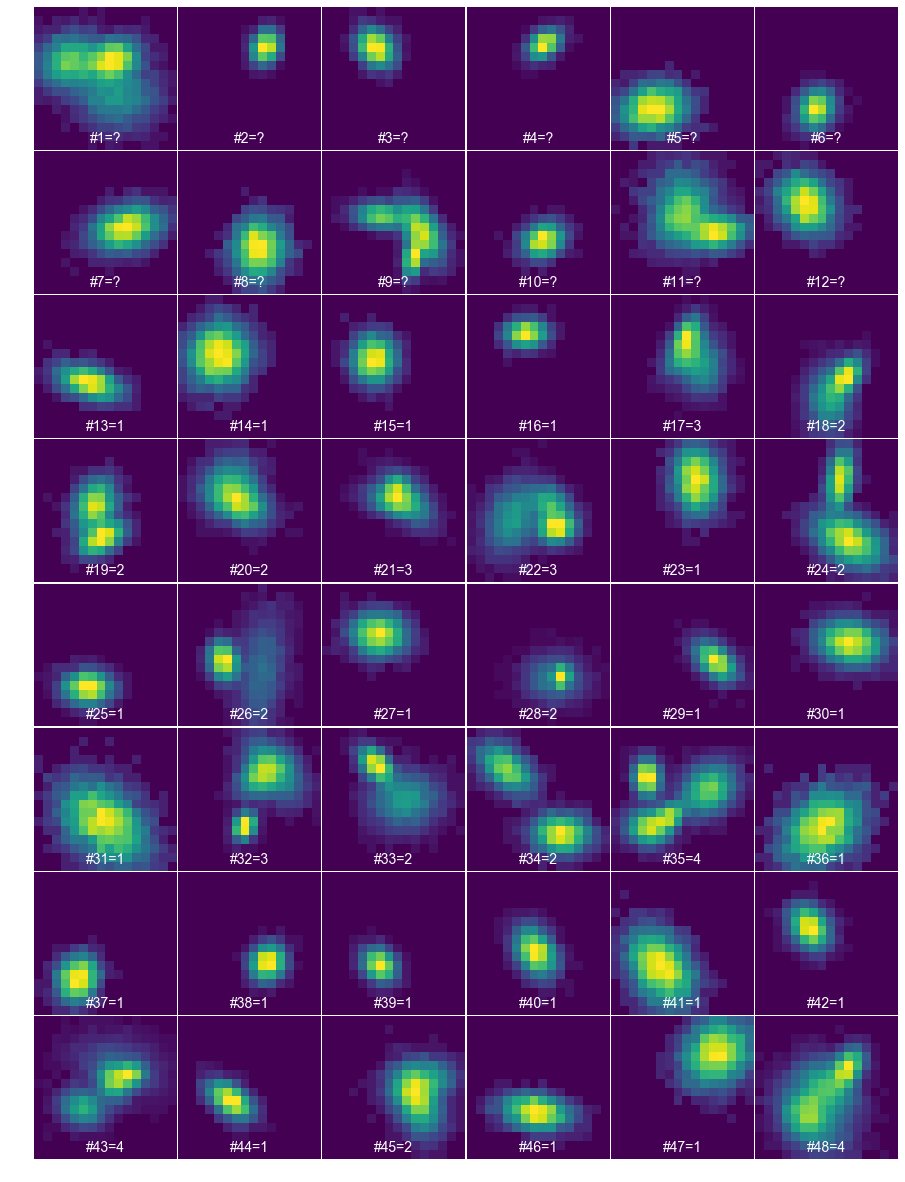

In [4]:
def scan_images(nrow=8, ncol=6, ntest=12, idx0=0, save='img/scan.png'):
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True,
                             figsize=(2 * ncol, 2 * nrow), frameon=False)
    idx = idx0
    for row in range(nrow):
        for col in range(ncol):
            ax = axes[row, col]
            label = f'#{idx-idx0+1}='
            label += '?' if idx - idx0 < ntest else f'{nsrc[idx]}'
            plot_image(df_img.iloc[idx].values, ax=ax, label=label)
            idx += 1
    plt.subplots_adjust(hspace=0.05 / (nrow - 1), wspace=0.05 / (ncol - 1),
                        left=0, right=1, bottom=0, top=1)
    plt.savefig(save)
            
scan_images()

Read the survey reponses:

In [5]:
def get_responses(name='data/scan-responses.csv', ntest=12):
    responses = pd.read_csv(name)
    nresponse = len(responses)
    nsrc = np.empty((ntest, nresponse))
    probs = np.empty((ntest, 4))
    for k in range(ntest):
        nsrc = responses.iloc[:, k + 1].str[:1].astype(int).values
        probs[k], _ = np.histogram(nsrc, bins=np.linspace(0.5, 4.5, 5), density=True)
    return probs

probs_human = get_responses()

Read the DNN classification probabilities written by [this notebook](NeuralNet.ipynb):

In [6]:
probs_dnn = pd.read_hdf('data/probs_dnn.hf5').values

Compare probabilities for the 12 test images:

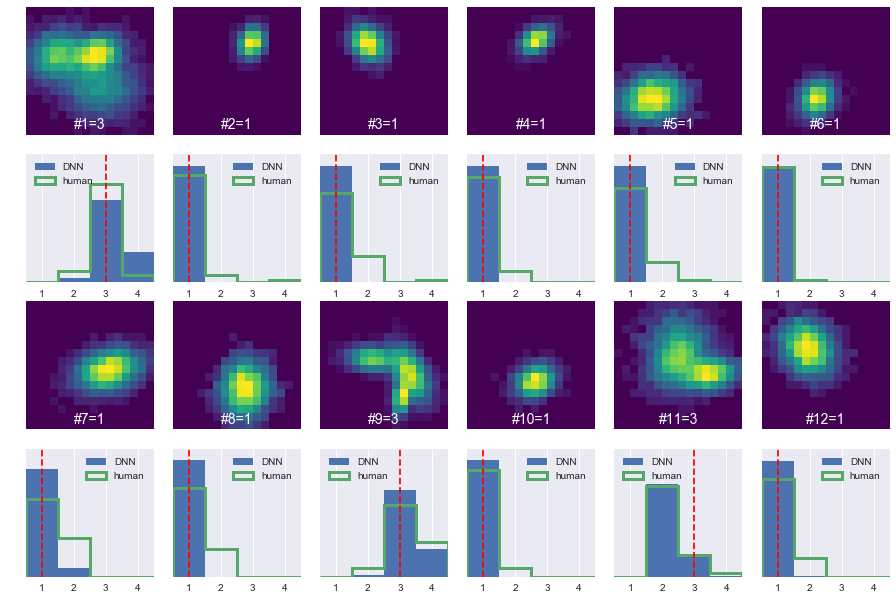

In [7]:
def show_probs(idx0=0, save='img/scan_results.png'):
    nrow, ncol = 4, 6
    fig, axes = plt.subplots(
        nrow, ncol, figsize=(2 * ncol, 2.2 * nrow), frameon=False)
    bins = np.linspace(0.5, 4.5, 5)
    centers = np.arange(1, 5)
    for row in range(nrow):
        for col in range(ncol):
            ax = axes[row, col]
            idx = idx0 + (row // 2) * ncol + col
            n = nsrc[idx]
            if row % 2 == 0:
                plot_image(df_img.iloc[idx].values, ax=ax,
                           label=f'#{idx-idx0+1}={n}')
            else:
                ax.hist(centers, weights=probs_dnn[idx], bins=bins, histtype='stepfilled',
                         label='DNN', density=True)
                ax.hist(centers, weights=probs_human[idx], bins=bins, histtype='step',
                         label='human', density=True, lw=3)
                ax.axvline(n, c='r', ls='--')
                ax.set_xlim(0.5, 4.5)
                ax.set_ylim(0, 1.1)
                ax.set_xticks(centers)
                ax.set_yticks([])
                ax.legend()
    plt.subplots_adjust(left=0, right=1, bottom=0.1, top=1, hspace=0.15, wspace=0.15)
    plt.savefig(save)
                
show_probs()

Notes:
 - Only one case (#11) where correct answer is not the most popular (for both DNN and human).
 - Only one case (#1) where DNN is more confident of a wrong answer than human.
 - Only one case (#1) where human is more confident of its correct answer than DNN.
 - Human and DDN essentially indistinguishable for two cases (#5, #11).